# 📘 Agentic Architectures 2: Tool Use

This notebook covers the second, and arguably one of the most transformative, agentic architectures: **Tool Use**. This pattern is the bridge that connects a Large Language Model's reasoning capabilities to the real, dynamic world.

Without tools, an LLM is a closed system, limited by the knowledge frozen into its training data. It cannot know today's weather, the current price of a stock, or the status of an order in your company's database. By giving an agent the ability to use tools, we empower it to overcome this fundamental limitation, allowing it to query APIs, search databases, and access live information to provide answers that are not just reasoned, but also factual, timely, and relevant.

### Definition
The **Tool Use** architecture equips an LLM-powered agent with the ability to call external functions or APIs (the "tools"). The agent autonomously decides when a user's query cannot be answered by its internal knowledge alone and determines which tool is appropriate to call to find the necessary information.

### High-level Workflow

1.  **Receive Query:** The agent receives a request from the user.
2.  **Decision:** The agent analyzes the query and its available tools. It decides if a tool is needed to answer the question accurately.
3.  **Action:** If a tool is needed, the agent formats a call to that tool (e.g., a specific function with the right arguments).
4.  **Observation:** The system executes the tool call, and the result (the "observation") is returned to the agent.
5.  **Synthesis:** The agent integrates the tool's output into its reasoning process to generate a final, grounded answer for the user.

### When to Use / Applications
*   **Research Assistants:** Answering questions that require up-to-the-minute information by using a web search API.
*   **Enterprise Assistants:** Querying internal company databases to answer questions like "How many new users signed up last week?"
*   **Scientific & Mathematical Tasks:** Using a calculator or a computational engine like WolframAlpha for precise calculations that LLMs often struggle with.

### Strengths & Weaknesses
*   **Strengths:**
    *   **Factual Grounding:** Drastically reduces hallucinations by fetching real, live data.
    *   **Extensibility:** The agent's capabilities can be continuously expanded by simply adding new tools.
*   **Weaknesses:**
    *   **Integration Overhead:** Requires careful "plumbing" to define tools, handle API keys, and manage potential tool failures.
    *   **Tool Trust:** The quality of the agent's answer is dependent on the reliability and accuracy of the tools it uses. The agent must trust that its tools provide correct information.

## Phase 0: Foundation & Setup

As before, we begin by setting up our environment. This includes installing the necessary libraries and configuring our API keys for Nebius, LangSmith, and the specific tool we will be using.

### Step 0.1: Installing Core Libraries

**What we are going to do:**
We'll install our standard set of libraries for orchestration (`langchain-nebius`, `langgraph`), environment management (`python-dotenv`), and printing (`rich`). Crucially, we will also install `tavily-python`, which provides a simple-to-use API for a powerful web search tool that we will give to our agent.

In [1]:
# !pip install -q -U langchain-nebius langchain langgraph rich python-dotenv tavily-python

### Step 0.2: Importing Libraries and Setting Up Keys

**What we are going to do:**
We will import the necessary modules and use `python-dotenv` to load our API keys. For this notebook, we need keys for Nebius (for the LLM), LangSmith (for tracing), and Tavily (for the web search tool).

**Action Required:** Create a `.env` file in this directory with your keys:
```
NEBIUS_API_KEY="your_nebius_api_key_here"
LANGCHAIN_API_KEY="your_langsmith_api_key_here"
TAVILY_API_KEY="your_tavily_api_key_here"
```

In [4]:
import os
import json
from typing import List, Annotated, TypedDict, Optional
from dotenv import load_dotenv

# LangChain components
from langchain_nebius import ChatNebius
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, ToolMessage
from pydantic import BaseModel, Field

# LangGraph components
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode

# For pretty printing
from rich.console import Console
from rich.markdown import Markdown
from langchain_openai import ChatOpenAI

# --- API Key and Tracing Setup ---
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic Architecture - Tool Use (Nebius)"

# Check that the keys are set
for key in ["NEBIUS_API_KEY", "LANGCHAIN_API_KEY", "TAVILY_API_KEY"]:
    if not os.environ.get(key):
        print(f"{key} not found. Please create a .env file and set it.")

print("Environment variables loaded and tracing is set up.")

Environment variables loaded and tracing is set up.


## Phase 1: Defining the Agent's Toolkit

An agent is only as capable as the tools it has access to. In this phase, we will define and test the specific tool we'll give our agent: a live web search.

### Step 1.1: Creating and Testing the Web Search Tool

**What we are going to do:**
We will instantiate the `TavilySearchResults` tool. The most critical part of defining a tool is its **description**. The LLM uses this natural language description to understand what the tool does and when it should be used. A clear, precise description is essential for the agent to make correct decisions. We will then test the tool directly to see what its raw output looks like.

In [5]:
# Initialize the tool. We can set the max number of results to keep the context concise.
search_tool = TavilySearchResults(max_results=2)

# It's crucial to give the tool a clear name and description for the agent
search_tool.name = "web_search"
search_tool.description = "A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs."

tools = [search_tool]
print(f"Tool '{search_tool.name}' created with description: '{search_tool.description}'")

console = Console()

# Let's test the tool directly to see its output format
print("\n--- Testing the tool directly ---")
test_query = "What was the score of the last Super Bowl?"
test_result = search_tool.invoke({"query": test_query})
console.print(f"[bold green]Query:[/bold green] {test_query}")
console.print("\n[bold green]Result:[/bold green]")
console.print(test_result)

Tool 'web_search' created with description: 'A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs.'

--- Testing the tool directly ---


Query: What was the score of the last Super Bowl?

Result:

[
    {
        'title': 'List of Super Bowl champions - Wikipedia',
        'url': 'https://en.wikipedia.org/wiki/List_of_Super_Bowl_champions',
        'content': '| Game | Date (Season) | Winning team | Score | Losing team | Venue | City | Attendance | 
Referee | Ref. |\n| I  | January 15, 1967 (1966 AFL/1966 NFL) | Green Bay Packersn (1, 1–0) | 35–10 | Kansas City 
Chiefsa (1, 0–1) | Los Angeles Memorial Coliseum | Los Angeles, California | 61,946 | Norm Schachter |  |\n| II  | 
January 14, 1968 (1967 AFL/1967 NFL) | Green Bay Packersn (2, 2–0) | 33–14 | Oakland Raidersa (1, 0–1) | Miami 
Orange Bowl | Miami, Florida | 75,546 | Jack Vest |  |\n| III  | January 12, 1969 (1968 AFL/1968 NFL) | New York 
Jetsa (1, 1–0) | 16–7 | Baltimore Coltsn (1, 0–1) | Miami Orange Bowl (2) | Miami, Florida (2) | 75,389 | Tom Bell 
"Tommy Bell (American football official)") |  | [...] | XLIII | February 1, 2009 (2008) | Pittsburgh SteelersA (7, 
6–1) | 27–23 | Arizona CardinalsN (1, 0–1) | Raymond James Stadium (2) | Tampa, Florida (4) | 70,774 | Terry 
McAulay |  |\n| XLIV | February 7, 2010 (2009) | New Orleans SaintsN (1, 1–0) | 31–17 | Indianapolis ColtsA (4, 
2–2) | Sun Life Stadium (5) | Miami Gardens, Florida (10) | 74,059 | Scott Green "Scott Green (American football 
official)") |  |\n| XLV | February 6, 2011 (2010) | Green Bay PackersN (5, 4–1) (#endnote_WildCardW) | 31–25 | 
Pittsburgh SteelersA (8, 6–2) | Cowboys Stadium | Arlington, Texas | 103,219 | Walt Anderson "Walt Anderson 
(American football)") |  | [...] | XLVI | February 5, 2012 (2011) | New York GiantsN (5, 4–1) | 21–17 | New England
PatriotsA (7, 3–4) | Lucas Oil Stadium | Indianapolis, Indiana | 68,658 | John Parry "John Parry (American football
official)") |  |\n| XLVII | February 3, 2013 (2012) | Baltimore RavensA (2, 2–0) | 34–31 | San Francisco 49ersN (6,
5–1) | Mercedes-Benz Superdome (7) | New Orleans, Louisiana (10) | 71,024 | Jerome Boger |  |\n| XLVIII | February 
2, 2014 (2013) | Seattle SeahawksN (2, 1–1) | 43–8 | Denver BroncosA (7, 2–5) | MetLife Stadium | East Rutherford, 
New Jersey | 82,529 | Terry McAulay |  |\n| XLIX | February 1, 2015 (2014) | New England PatriotsA (8, 4–4) | 28–24
| Seattle SeahawksN (3, 1–2) | University of Phoenix Stadium (2) | Glendale, Arizona (3) | 70,288 | Bill Vinovich |
|',
        'score': 0.6780931
    },
    {
        'title': 'Super Bowl Scores Last 10 Years | StatMuse',
        'url': 'https://www.statmuse.com/nfl/ask/super-bowl-scores-last-10-years',
        'content': 'Sign in/up\n\n NFL\n CFB\n NBA\n FC\n NHL\n MLB\n WNBA\n PGA\n Money\n\n Trending Sports\n 
Trending Money\n Trending Live\n\n Data & Glossary\n\nSign in/up\n\nSign in/up\n\n Home\n\n NFL\n CFB\n NBA\n FC\n 
NHL\n MLB\n WNBA\n PGA\n Money\n\n Scores\n\n Trending\n\n Trending Sports\n Trending Money\n Trending Live\n\n 
Examples\n\n Data & Glossary\n\n Gallery\n\n About\n\n Blog\n\n Shop\n\n# The Philadelphia Eagles dominated the 
Kansas City Chiefs, 40 to 22, in Super Bowl LIX on February 9.\n\nSun, Feb 9, 2025\n\nSun, Feb 11, 
2024\n\n22\n\nChiefs\n\nFinal\n\nSun, Feb 12, 2023\n\nChiefs\n\nEagles\n\nFinal\n\nSun, Feb 13, 
2022\n\n20\n\nFinal\n\nSun, Feb 7, 2021\n\nChiefs\n\n9\n\nBuccaneers\n\n31\n\nFinal\n\nSun, Feb 2, 
2020\n\n49ers\n\n20\n\nChiefs\n\n31\n\nFinal\n\nSun, Feb 3, 2019\n\nPatriots\n\n13\n\nRams\n\n3\n\nFinal\n\nSun, 
Feb 4, 2018\n\nEagles\n\n41\n\nPatriots\n\n33\n\nFinal\n\nSun, Feb 5, 2017\n\nPatriots\n\n34 [...] | NFC East | W |
L | T | PCT |\n ---  --- \n| Eagles - y | 11 | 5 | 0 | .688 |\n| Cowboys - e | 7 | 8 | 1 | .469 |\n| Commanders - e
| 4 | 12 | 0 | .250 |\n| Giants - e | 3 | 13 | 0 | .188 |\n| NFC North | W | L | T | PCT |\n| Bears - y | 11 | 5 | 
0 | .688 |\n| Packers - w | 9 | 6 | 1 |  |\n| Vikings - e | 8 | 8 | 0 | .500 |\n| Lions - e | 8 | 8 | 0 | .500 |\n|
NFC South | W | L | T | PCT |\n| Panthers | 8 | 8 | 0 | .500 |\n| Buccaneers | 7 | 9 | 0 | .438 |\n| Falcons - e | 
7 | 9 | 0 | .438 |\n| Saints - e | 6 | 10 | 0 | .

**Discussion of the Output:**
The test shows the raw output of our `web_search` tool. It returns a list of dictionaries, where each dictionary contains the URL and content snippet of a search result. This structured information is exactly what the agent will receive as its "observation" after it decides to use the tool. Now that we have a functional tool, we can build the agent that will learn how to use it.

## Phase 2: Building the Tool-Using Agent with LangGraph

Now we will construct the agentic workflow. This involves making the LLM aware of the tools and creating a graph that allows it to loop through a "think-act-observe" cycle, which is the essence of tool use.

### Step 2.1: Defining the Graph State

**What we are going to do:**
The state for a tool-using agent is typically a list of messages that represents the conversation history. This history includes the user's questions, the agent's thoughts and tool calls, and the results from those tools. We will use a `TypedDict` that can hold any type of LangChain message.

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

print("AgentState TypedDict defined to manage conversation history.")

AgentState TypedDict defined to manage conversation history.


### Step 2.2: Binding the Tools to the LLM

**What we are going to do:**
This is the critical step where we make the LLM "aware" of the tools. We use the `.bind_tools()` method, which passes the names and descriptions of our tools to the LLM's system prompt. This allows the model's internal logic to decide when to call a tool based on its description.

In [6]:
# llm = ChatNebius(model="meta-llama/Meta-Llama-3.1-8B-Instruct", temperature=0)
llm = ChatOpenAI(model='gpt-4o-mini')

# Bind the tools to the LLM, making it tool-aware
llm_with_tools = llm.bind_tools(tools)

print("LLM has been bound with the provided tools.")

LLM has been bound with the provided tools.


### Step 2.3: Defining the Agent Nodes

**What we are going to do:**
Our graph will have two main nodes:
1.  **`agent_node`:** This is the "brain". It calls the LLM with the current conversation history. The LLM's response will either be a final answer or a request to call a tool.
2.  **`tool_node`:** This is the "hands". It takes the tool call request from the `agent_node`, executes the corresponding tool, and returns the output. We will use LangGraph's pre-built `ToolNode` for this.

In [20]:
def agent_node(state: AgentState):
    """The primary node that calls the LLM to decide the next action."""
    console.print("--- AGENT: Thinking... ---")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# The ToolNode is a pre-built node from LangGraph that executes tools
tool_node = ToolNode(tools)

print("Agent node and Tool node have been defined.")

Agent node and Tool node have been defined.


### Step 2.4: Defining the Conditional Router

**What we are going to do:**
After the `agent_node` runs, we need to decide where to go next. The router function inspects the last message from the agent. If that message contains a `tool_calls` attribute, it means the agent wants to use a tool, so we route to the `tool_node`. If not, it means the agent has a final answer, and we can end the workflow.

In [21]:
def router_function(state: AgentState) -> str:
    """Inspects the agent's last message to decide the next step."""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        # The agent has requested a tool call
        console.print("--- ROUTER: Decision is to call a tool. ---")
        return "call_tool"
    else:
        # The agent has provided a final answer
        console.print("--- ROUTER: Decision is to finish. ---")
        return "__end__"

print("Router function defined.")

Router function defined.


## Phase 3: Assembling and Running the Workflow

Now we'll wire all the components together into a complete, executable graph and run it on a query that forces the agent to use its new web search capability.

### Step 3.1: Building and Visualizing the Graph

**What we are going to do:**
We will create the `StateGraph` and add our nodes and edges. The key part is the conditional edge that uses our `router_function` to create the agent's primary reasoning loop: `agent -> router -> tool -> agent`.

Tool-using agent graph compiled successfully!


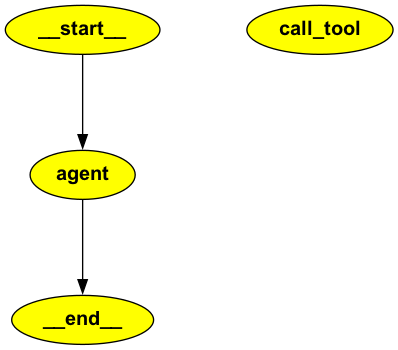

In [22]:
graph_builder = StateGraph(AgentState)

# Add the nodes
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("call_tool", tool_node)

# Set the entry point
graph_builder.set_entry_point("agent")

# Add the conditional router
graph_builder.add_conditional_edges(
    "agent",
    router_function,
)

# Add the edge from the tool node back to the agent to complete the loop
graph_builder.add_edge("call_tool", "agent")

# Compile the graph
tool_agent_app = graph_builder.compile()

print("Tool-using agent graph compiled successfully!")

# Visualize the graph
try:
    from IPython.display import Image, display
    png_image = tool_agent_app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f"Graph visualization failed: {e}. Please ensure pygraphviz is installed.")

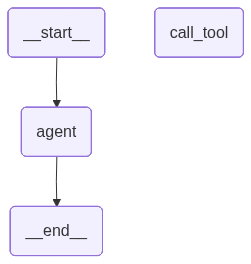

In [ ]:
Image(tool_agent_app.get_graph().draw_mermaid_png())

**Discussion of the Output:**
The compiled graph is ready. The visualization clearly shows the agent's reasoning loop. The process starts at the `agent` node. The conditional edge (represented by the diamond) then routes the flow. If a tool is needed, it goes to `call_tool`, and the output is fed back to the `agent` for synthesis. If no tool is needed, the process goes to `__end__`. This structure perfectly implements the Tool Use pattern.

### Step 3.2: End-to-End Execution

**What we are going to do:**
Let's run the agent with a question that it cannot possibly know from its training data, forcing it to use the web search tool. We will stream the intermediate steps to watch its reasoning process unfold.

In [24]:
user_query = "What were the main announcements from Apple's latest WWDC event?"
initial_input = {"messages": [("user", user_query)]}

console.print(f"[bold cyan]🚀 Kicking off Tool Use workflow for request:[/bold cyan] '{user_query}'\n")

for chunk in tool_agent_app.stream(initial_input, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
    console.print("\n---\n")

console.print("\n[bold green]✅ Tool Use workflow complete![/bold green]")

🚀 Kicking off Tool Use workflow for request: 'What were the main announcements from Apple's latest WWDC event?'

================================ Human Message =================================

What were the main announcements from Apple's latest WWDC event?


---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to call a tool. ---

================================== Ai Message ==================================
Tool Calls:
  web_search (call_ASHBDY8JKHsm80SIY7hdOPTB)
 Call ID: call_ASHBDY8JKHsm80SIY7hdOPTB
  Args:
    query: Apple WWDC 2023 announcements summary


---

================================= Tool Message =================================
Name: web_search

[{"title": "WWDC 2023 recap: All the big announcements - Tom's Guide", "url": "https://www.tomsguide.com/news/live/wwdc-2023-live-blog-apple-headset-new-macs-ios-17-and-more", "content": "It's that product, dubbed the Apple Vision Pro, that figures to be the most remembered announcement from today's news-packed keynote, even though the headset won't ship until next year at a if-you-have-to-ask-you-can't-afford-it price of $3,499. Apple says the Vision Pro is the first step in a new product category it's called spatial computing, and really this first headset seems like a way to get developers interested in building software for a virtual world. [...] Whether consumers share that interest won't be evident until the Vision Pro goes on sale in early 2024, but Apple touts it as a multipurpose device, letting you watch movies in more immersive way, have video chats with people floating right i

---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to finish. ---

================================== Ai Message ==================================

At Apple's WWDC 2023, several key announcements were made, highlighting new hardware and software developments. Here are the main highlights:

1. **Apple Vision Pro**: The most notable announcement was the introduction of the Apple Vision Pro, a mixed-reality headset. It is positioned as a pioneering device in the emerging category of spatial computing. Although it won't be available for purchase until early 2024, it comes with a price tag of $3,499. The Vision Pro allows users to engage in immersive experiences, including watching movies, engaging in video chats, and capturing layered photos and videos, all while remaining aware of their real-world surroundings.

2. **New Macs**: Apple introduced three new Mac models, completing its transition from Intel processors to its own Apple silicon. This includes the new 15-inch MacBook Air, which features an M2 chip, is 11.5mm thick, and weighs just over 3 pound

---

✅ Tool Use workflow complete!

## Phase 4: Evaluation

Now that the agent has run, we can evaluate its performance. For a tool-using agent, we care about two things: did it use its tools correctly, and was the final answer, which was synthesized from the tool's output, high-quality?

### Step 4.1: Analyzing the Execution Trace

**What we are going to do:**
By looking at the streamed output from the previous step, we can trace the agent's exact thought process. The output shows the different message types (`AIMessage` with `tool_calls`, `ToolMessage` with results) that flow through the graph state.

**Discussion of the Output:**
The execution trace clearly shows the Tool Use pattern in action:
1.  The first message printed is from the `agent` node. It's an `AIMessage` containing a `tool_calls` attribute, indicating the LLM correctly decided to use the `web_search` tool.
2.  The next message is a `ToolMessage`. This is the output from the `tool_node` after it executed the search and returned the raw results.
3.  The final message is another `AIMessage`, but this time without `tool_calls`. This is the agent synthesizing the information from the `ToolMessage` into a coherent, final answer for the user.
This trace confirms that the agent's logic and the graph's routing worked perfectly.

### Step 4.2: Evaluating with LLM-as-a-Judge

**What we are going to do:**
We will create a 'Judge' LLM to provide a structured, quantitative evaluation of the agent's performance. The evaluation criteria will be tailored specifically to assess the quality of tool use.

In [25]:
class ToolUseEvaluation(BaseModel):
    """Schema for evaluating the agent's tool use and final answer."""
    tool_selection_score: int = Field(description="Score 1-5 on whether the agent chose the correct tool for the task.")
    tool_input_score: int = Field(description="Score 1-5 on how well-formed and relevant the input to the tool was.")
    synthesis_quality_score: int = Field(description="Score 1-5 on how well the agent integrated the tool's output into its final answer.")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(ToolUseEvaluation)

# To evaluate, we need to reconstruct the full conversation trace
final_answer = tool_agent_app.invoke(initial_input)
conversation_trace = "\n".join([f"{m.type}: {m.content or ''} {getattr(m, 'tool_calls', '')}" for m in final_answer['messages']])

def evaluate_tool_use(trace: str):
    prompt = f"""You are an expert judge of AI agents. Evaluate the following conversation trace based on the agent's tool use on a scale of 1-5. Provide a brief justification.
    
    Conversation Trace:
    ```
    {trace}
    ```
    """
    return judge_llm.invoke(prompt)

console.print("--- Evaluating Tool Use Performance ---")
evaluation = evaluate_tool_use(conversation_trace)
console.print(evaluation.model_dump())

--- AGENT: Thinking... ---

--- ROUTER: Decision is to call a tool. ---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to call a tool. ---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to finish. ---

--- Evaluating Tool Use Performance ---

{
    'tool_selection_score': 5,
    'tool_input_score': 5,
    'synthesis_quality_score': 5,
    'justification': "The AI effectively used the tool 'web_search' to gather relevant information on Apple's WWDC 
2023 announcements. The search queries were well-defined and yielded high-quality sources, which the AI then 
synthesized into a clear and comprehensive summary of the major announcements. The final answer was well-organized 
and detailed, showcasing excellent integration of the tool's output."
}

**Discussion of the Output:**
The LLM-as-a-Judge provides a structured and reasoned assessment of our agent's performance. The high scores across all three categories—`tool_selection_score`, `tool_input_score`, and `synthesis_quality_score`—confirm that our agent is not just using tools, but using them *effectively*. It correctly identified the need for a web search, formulated a relevant query, and successfully synthesized the retrieved facts into a helpful and accurate final answer. This automated evaluation gives us confidence in the robustness of our implementation.

## Conclusion

In this notebook, we have built a complete, functioning agent based on the **Tool Use** architecture. We successfully equipped a Nebius-powered LLM with a web search tool and used LangGraph to create a robust reasoning loop that allows the agent to decide when and how to use it.

The end-to-end execution and subsequent evaluation demonstrate the immense value of this pattern. By connecting our agent to live, external information, we have fundamentally overcome the limitation of static training data. The agent is no longer just a reasoner; it is a researcher, capable of providing answers that are grounded, factual, and current. This architecture is a foundational building block for creating virtually any practical, real-world AI assistant.